In [ ]:
!git clone https://github.com/augmentedstartups/yolov7.git
!cd Trashminator/yolov7_files
%pip install -r requirements.txt
%pip install roboflow

In [ ]:
!cd Trashminator/yolov7_files

from roboflow import Roboflow
rf = Roboflow(api_key="r0pIMR1W3kYScV2VBpqo")
project = rf.workspace("nam-nhat").project("trash-dvdrr")
dataset = project.version(5).download("yolov7")

In [ ]:
%cd yolov7_files
%pwd

%cd yolov7
%pwd

In [ ]:
%%bash
wget -P /Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7 https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
%pwd

In [ ]:
!python train.py --batch 16 --cfg /Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7/cfg/training/yolov7.yaml --epochs 55 --data /Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7/Trash-5/data.yaml --weights "yolov7.pt" --device 1

In [ ]:
# Run evaluation
!python detect.py --weights /Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/epoch_054.pt --conf 0.1 --source /Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7/Trash-5/test/images

In [ ]:
# #display inference on ALL test images

# import glob
# from IPython.display import Image, display

# i = 0
# limit = 10000 # max images to print
# for imageName in glob.glob('/Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7/runs/detect/exp'):
#     #Assuming JPG
#     if i < limit:
#       display(Image(filename=imageName))
#       print("\n")
#     i = i + 1

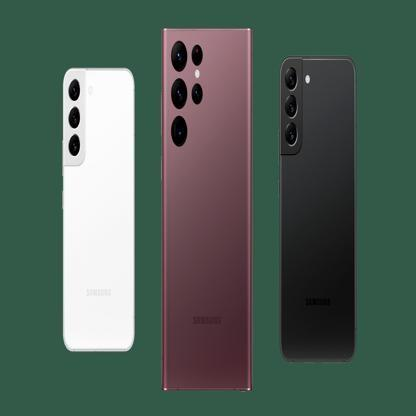

In [3]:
from IPython.display import Image
display(Image("/Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/yolov7/Trash-5/test/images/1_jpg.rf.95596861db3483c9f453296ddf305f68.jpg", width=200, height=100))

## Inference on custom images

In [4]:
classes_to_filter = None  #You can give list of classes to filter by name, Be happy you don't have to put class number. ['train','person' ]


opt  = {
    
    "weights": "/Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files/epoch_054.pt", # Path to weights file default weights are for nano model
    "yaml"   : "Trash-5/data.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : 'cpu',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None
    
}

In [5]:
#give the full path to video, your video will be in the Yolov7 folder
video_path = '/Users/karthik/Documents/GitHub/Codeoverflow_nyp/sample_video.mp4'

In [11]:
import os
import sys
import seaborn as sns
sys.path.append('/Users/karthik/Documents/GitHub/Codeoverflow_nyp/Trashminator/yolov7_files')
import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

## Inference on videos

In [13]:
def detectorTrash(video_path):
    # initialize the video object
    video = cv2.VideoCapture(video_path)

    # Video information
    fps = video.get(cv2.CAP_PROP_FPS)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # initialize the object for the output video
    output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (width,height))
    torch.cuda.empty_cache()

    # Initialize model and set it for inference
    with torch.no_grad():
        weights, imgsz = opt['weights'], opt['img-size']
        set_logging()
        device = select_device(opt['device'])
        half = device.type != 'cpu'
        model = attempt_load(weights, map_location=device)  # load FP32 model
        stride = int(model.stride.max())  # model stride
        imgsz = check_img_size(imgsz, s=stride)  # check img_size

        if half:
            model.half()

        names = model.module.names if hasattr(model, 'module') else model.names
        colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
        if device.type != 'cpu':
          model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

        classes = None
        if opt['classes']:
          classes = []
          for class_name in opt['classes']:
            classes.append(opt['classes'].index(class_name))

        for j in range(nframes):
          ret, img0 = video.read()
          if ret:
            img = letterbox(img0, imgsz, stride=stride)[0]
            img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
            img = np.ascontiguousarray(img)
            img = torch.from_numpy(img).to(device)
            img = img.half() if half else img.float()  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
            if img.ndimension() == 3:
              img = img.unsqueeze(0)

            # Inference
            t1 = time_synchronized()
            pred = model(img, augment= False)[0]

            
            pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
            t2 = time_synchronized()
            for i, det in enumerate(pred):
              s = ''
              s += '%gx%g ' % img.shape[2:]  # print string
              gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
              if len(det):
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

                for c in det[:, -1].unique():
                  n = (det[:, -1] == c).sum()  # detections per class
                  s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        
                for *xyxy, conf, cls in reversed(det):

                  label = f'{names[int(cls)]} {conf:.2f}'
                  plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
            
            print(f"{j+1}/{nframes} frames processed")
            output.write(img0)
          else:
            break
        

    output.release()
    video.release()
    return True


detectorTrash('/Users/karthik/Documents/GitHub/Codeoverflow_nyp/sample_video.mp4')

        


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
YOLOR 🚀 0564d77 torch 1.12.1 CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Model Summary: 314 layers, 36487166 parameters, 6194944 gradients


RepConv.fuse_repvgg_block
IDetect.fuse
1/1234 frames processed
2/1234 frames processed
3/1234 frames processed
4/1234 frames processed
5/1234 frames processed
6/1234 frames processed
7/1234 frames processed
8/1234 frames processed
9/1234 frames processed
10/1234 frames processed
11/1234 frames processed
12/1234 frames processed
13/1234 frames processed
14/1234 frames processed
15/1234 frames processed
16/1234 frames processed
17/1234 frames processed
18/1234 frames processed
19/1234 frames processed
20/1234 frames processed
21/1234 frames processed
22/1234 frames processed
23/1234 frames processed
24/1234 frames processed
25/1234 frames processed
26/1234 frames processed
27/1234 frames processed
28/1234 frames processed
29/1234 frames processed
30/1234 frames processed
31/1234 frames processed
32/1234 frames processed
33/1234 frames processed
34/1234 frames processed
35/1234 frames processed
36/1234 frames processed
37/1234 frames processed
38/1234 frames processed
39/1234 frames proce

In [12]:

# Initializing video object
video = cv2.VideoCapture(video_path)


# Video information
fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialzing object for writing video output
output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
torch.cuda.empty_cache()
# Initializing model and setting it for inference
with torch.no_grad():
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size
  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(opt['classes'].index(class_name))

  for j in range(nframes):

      ret, img0 = video.read()
      if ret:
        img = letterbox(img0, imgsz, stride=stride)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
          img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]

        
        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):
          s = ''
          s += '%gx%g ' % img.shape[2:]  # print string
          gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
          if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
    
            for *xyxy, conf, cls in reversed(det):

              label = f'{names[int(cls)]} {conf:.2f}'
              plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
        
        print(f"{j+1}/{nframes} frames processed")
        output.write(img0)
      else:
        break
    

output.release()
video.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
YOLOR 🚀 fd14097 torch 1.12.1 CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Model Summary: 314 layers, 36487166 parameters, 6194944 gradients


IDetect.fuse


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)


1/1234 frames processed
2/1234 frames processed
3/1234 frames processed
4/1234 frames processed
5/1234 frames processed
6/1234 frames processed
7/1234 frames processed
8/1234 frames processed
9/1234 frames processed
10/1234 frames processed
11/1234 frames processed
12/1234 frames processed
13/1234 frames processed
14/1234 frames processed
15/1234 frames processed
16/1234 frames processed
17/1234 frames processed
18/1234 frames processed
19/1234 frames processed
20/1234 frames processed
21/1234 frames processed
22/1234 frames processed
23/1234 frames processed
24/1234 frames processed
25/1234 frames processed
26/1234 frames processed
27/1234 frames processed
28/1234 frames processed
29/1234 frames processed
30/1234 frames processed
31/1234 frames processed
32/1234 frames processed
33/1234 frames processed
34/1234 frames processed
35/1234 frames processed
36/1234 frames processed
37/1234 frames processed
38/1234 frames processed
39/1234 frames processed
40/1234 frames processed
41/1234 f